In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
customer_features = pd.read_csv('customer_features_complete.csv')

print(f"Dataset shape: {customer_features.shape}")
print(f"Total features: {customer_features.shape[1] - 1}")

Dataset shape: (1986574, 107)
Total features: 106


In [3]:
segmentation_features = [
    # Core Features (13)
    'total_orders', 'unique_products', 'total_quantity', 'avg_quantity_per_order',
    'total_revenue', 'avg_revenue_per_order', 'total_profit', 'avg_price_point',
    'price_std', 'min_price_paid', 'max_price_paid', 'active_days', 'customer_lifetime_days',
    
    # Behavioral Patterns (2)
    'avg_days_between_orders', 'std_days_between_orders',
    
    # Diversity Metrics (4)
    'unique_brands', 'unique_l0_categories', 'unique_l1_categories', 'unique_l2_categories',
    
    # Loyalty Metrics (3)
    'brand_loyalty_score', 'category_focus_score', 'product_repeat_rate',
    
    # Financial Metrics (2)
    'profit_margin', 'discount_ratio',
    
    # Discount Behavior (6)
    'no_discount_purchase_pct', 'small_discount_pct', 'medium_discount_pct',
    'high_discount_pct', 'avg_discount_needed', 'discount_sensitivity',
    
    # Cross-Category Behavior (6)
    'avg_categories_per_order', 'avg_brands_per_order', 'avg_products_per_order',
    'single_category_orders_pct', 'multi_category_orders_pct', 'bulk_orders_pct',
    
    # Price Behavior (2)
    'price_variance', 'price_cv',
    
    # Velocity (1)
    'purchase_velocity',
    
    # Advanced (1)
    'product_diversity_score'
]

# Extract segmentation features
seg_data = customer_features[segmentation_features].copy()

print(f"Segmentation features: {len(segmentation_features)}")

Segmentation features: 40


In [ ]:
print("Missing Values:")
missing = seg_data.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing: {missing.sum()}")

Missing Values:
Series([], dtype: int64)

Total missing: 0


In [7]:
corr_matrix = seg_data.corr()

# Find high correlations (>0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(f"High correlations (>0.9): {len(high_corr)}")
for f1, f2, corr in high_corr:
    print(f"{f1} <-> {f2}: {corr:.3f}")

High correlations (>0.9): 21
total_orders <-> active_days: 0.981
unique_products <-> total_quantity: 0.915
unique_products <-> unique_brands: 0.960
unique_products <-> unique_l1_categories: 0.962
unique_products <-> unique_l2_categories: 0.970
total_quantity <-> total_revenue: 0.910
unique_brands <-> unique_l0_categories: 0.905
unique_brands <-> unique_l1_categories: 0.978
unique_brands <-> unique_l2_categories: 0.983
unique_l0_categories <-> unique_l1_categories: 0.932
unique_l0_categories <-> unique_l2_categories: 0.918
unique_l1_categories <-> unique_l2_categories: 0.996
profit_margin <-> discount_ratio: -0.994
no_discount_purchase_pct <-> high_discount_pct: -0.918
avg_categories_per_order <-> avg_brands_per_order: 0.962
avg_categories_per_order <-> avg_products_per_order: 0.939
avg_categories_per_order <-> product_diversity_score: 0.920
avg_brands_per_order <-> avg_products_per_order: 0.912
avg_brands_per_order <-> product_diversity_score: 0.902
avg_products_per_order <-> product_d

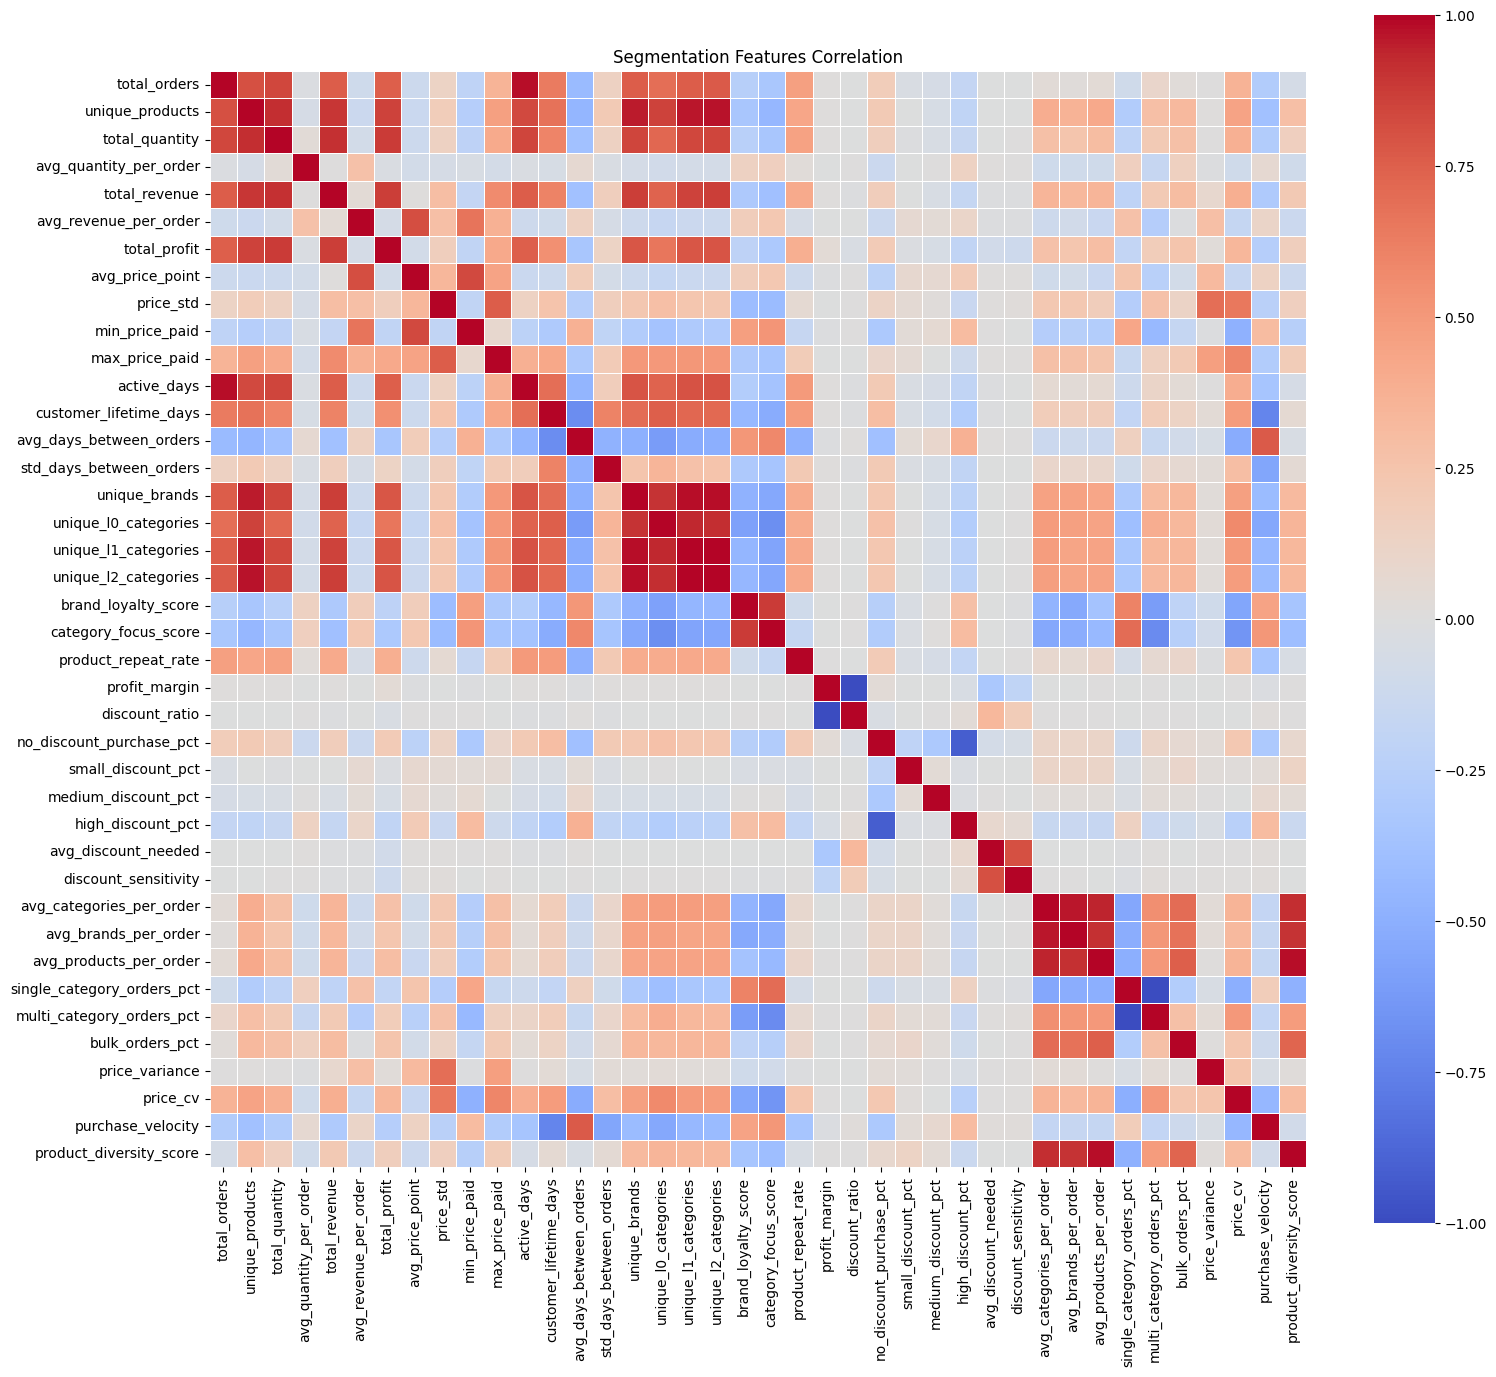

In [ ]:
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Segmentation Features Correlation')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=100)
plt.show()

In [9]:
features_to_drop = [
    'unique_l2_categories',      # 0.996 with unique_l1_categories
    'discount_ratio',            # -0.994 with profit_margin
    'multi_category_orders_pct', # -1.000 with single_category_orders_pct
    'product_diversity_score'    # 0.978 with avg_products_per_order
]

segmentation_features_clean = [f for f in segmentation_features 
                               if f not in features_to_drop]

seg_data_clean = customer_features[segmentation_features_clean]

print(f"Features: {len(segmentation_features)} → {len(segmentation_features_clean)}")
print(f"Dropped: {features_to_drop}")

Features: 40 → 36
Dropped: ['unique_l2_categories', 'discount_ratio', 'multi_category_orders_pct', 'product_diversity_score']


## Why These Features Were Removed

**1. unique_l2_categories** (r=0.996 with unique_l1_categories)
- L2 sub-categories are too granular and nearly identical to L1
- L1 mid-level categories provide sufficient diversity measurement

**2. discount_ratio** (r=-0.994 with profit_margin)  
- Both measure financial efficiency over total_revenue
- profit_margin is more business-relevant
- Discount behavior already captured in 6 discount_pct features

**3. multi_category_orders_pct** (r=-1.000 with single_category_orders_pct)
- Perfect inverse - they sum to 100%
- Keeping one provides the same information

**4. product_diversity_score** (r=0.978 with avg_products_per_order)
- Calculated as unique_products/total_orders
- Essentially the same as avg_products_per_order

In [10]:
percentage_features = [
    'profit_margin', 'brand_loyalty_score', 'category_focus_score', 
    'product_repeat_rate', 'no_discount_purchase_pct', 'small_discount_pct',
    'medium_discount_pct', 'high_discount_pct', 'avg_discount_needed',
    'single_category_orders_pct', 'bulk_orders_pct'
]

print("\nPercentage features outside 0-100 range:")
for feat in percentage_features:
    if feat in seg_data_clean.columns:
        below = (seg_data_clean[feat] < 0).sum()
        above = (seg_data_clean[feat] > 100).sum()
        if below > 0 or above > 0:
            print(f"\n{feat}:")
            print(f"  < 0: {below:,} ({below/len(seg_data_clean)*100:.2f}%)")
            print(f"  > 100: {above:,} ({above/len(seg_data_clean)*100:.2f}%)")
            print(f"  Min: {seg_data_clean[feat].min():.2f}, Max: {seg_data_clean[feat].max():.2f}")

# Check for extreme outliers (>3 std from mean)
print("\n" + "="*80)
print("Extreme outliers (>3 std from mean):")
for col in seg_data_clean.select_dtypes(include=[np.number]).columns:
    mean = seg_data_clean[col].mean()
    std = seg_data_clean[col].std()
    outliers = ((seg_data_clean[col] - mean).abs() > 3 * std).sum()
    if outliers > len(seg_data_clean) * 0.01:  # More than 1%
        print(f"\n{col}: {outliers:,} ({outliers/len(seg_data_clean)*100:.2f}%)")


Percentage features outside 0-100 range:

profit_margin:
  < 0: 307,136 (15.46%)
  > 100: 13 (0.00%)
  Min: -157611.59, Max: 95595.24

avg_discount_needed:
  < 0: 0 (0.00%)
  > 100: 31,302 (1.58%)
  Min: 0.00, Max: 99900.00

Extreme outliers (>3 std from mean):

total_orders: 42,944 (2.16%)

unique_products: 45,990 (2.32%)

total_quantity: 40,930 (2.06%)

avg_quantity_per_order: 24,578 (1.24%)

total_revenue: 43,017 (2.17%)

avg_revenue_per_order: 28,783 (1.45%)

total_profit: 39,135 (1.97%)

avg_price_point: 26,911 (1.35%)

price_std: 31,884 (1.60%)

min_price_paid: 57,088 (2.87%)

max_price_paid: 32,642 (1.64%)

active_days: 46,519 (2.34%)

std_days_between_orders: 44,273 (2.23%)

unique_brands: 42,248 (2.13%)

unique_l1_categories: 40,465 (2.04%)

product_repeat_rate: 30,370 (1.53%)

no_discount_purchase_pct: 163,644 (8.24%)

medium_discount_pct: 28,268 (1.42%)

high_discount_pct: 141,024 (7.10%)

avg_categories_per_order: 39,600 (1.99%)

avg_brands_per_order: 41,489 (2.09%)

avg_p

In [15]:
# Look at extreme negative profit margins
extreme_negative = customer_features[customer_features['profit_margin'] < -1000].copy()
print(f"\nCustomers with profit_margin < -1000%: {len(extreme_negative):,}")

if len(extreme_negative) > 0:
    print("\nSample of extreme cases:")
    print(extreme_negative[['customer_id', 'total_orders', 'total_revenue', 'total_profit', 
                             'profit_margin', 'total_discount']].head(10))
    
    # Check if these have negative revenue
    neg_revenue = (extreme_negative['total_revenue'] < 0).sum()
    print(f"\nOf these, customers with negative revenue: {neg_revenue:,}")
    
    # Check the math
    print("\nProfit margin calculation check:")
    print("Formula: (total_profit / total_revenue) * 100")
    sample = extreme_negative.iloc[0]
    calc_margin = (sample['total_profit'] / sample['total_revenue']) * 100
    print(f"Sample customer {sample['customer_id']}:")
    print(f"  total_profit: {sample['total_profit']:.2f}")
    print(f"  total_revenue: {sample['total_revenue']:.2f}")
    print(f"  Calculated margin: {calc_margin:.2f}%")
    print(f"  Stored margin: {sample['profit_margin']:.2f}%")


Customers with profit_margin < -1000%: 704

Sample of extreme cases:
      customer_id  total_orders  total_revenue  total_profit  profit_margin  \
1581        10917             1          7.000  -1353.982710  -19342.610143   
1671        11365             2          4.000   -483.125660  -12078.141500   
2385        16372             2         14.000  -1916.103312  -13686.452229   
5011        34145             8        186.000 -10722.770870   -5764.930575   
5026        34193             1         58.000   -955.731700   -1647.813276   
9260        63499             1          4.001   -415.493158  -10384.732767   
9315        63925             1         12.000   -181.648434   -1513.736950   
9459        65240             1         12.000   -669.272554   -5577.271283   
9523        65910             1         82.000  -1449.785750   -1768.031402   
9841        68831             4         61.000  -2563.721721   -4202.822493   

      total_discount  
1581        1499.000  
1671         5

In [28]:
# Cell 29: Understand the real cause of extreme margins

print("="*80)
print("WHY 704 CUSTOMERS HAVE EXTREME MARGINS VS 231 BAD TRANSACTIONS")
print("="*80)

# Get the 704 customers with extreme margins
extreme_margin = customer_features[customer_features['profit_margin'] < -1000].copy()

# Check how many have the impossible transactions
extreme_with_bad_trans = extreme_margin['customer_id'].isin(
    sales[sales['discount_exceeds_revenue']]['customer_id']
).sum()

print(f"Customers with margin < -1000%: {len(extreme_margin):,}")
print(f"Of these, have impossible transactions: {extreme_with_bad_trans:,}")
print(f"Have OTHER issues: {len(extreme_margin) - extreme_with_bad_trans:,}")

# The real cause: Small revenue after discount
print("\n" + "="*80)
print("THE REAL ISSUE: Small revenue denominator")
print("="*80)
print("\nExample: Customer 10917")
print("  unit_price × qty = $1,506 (legitimate)")
print("  discount = $1,499 (< $1,506, so valid!)")
print("  revenue = $1,506 - $1,499 = $7")
print("  landing_price (cost) = $1,361")
print("  profit = $7 - $1,361 = -$1,354")
print("  margin = -$1,354 / $7 × 100 = -19,342%")
print("\n→ Discount is valid, but deep discount + high cost = extreme margin")

WHY 704 CUSTOMERS HAVE EXTREME MARGINS VS 231 BAD TRANSACTIONS
Customers with margin < -1000%: 704
Of these, have impossible transactions: 34
Have OTHER issues: 670

THE REAL ISSUE: Small revenue denominator

Example: Customer 10917
  unit_price × qty = $1,506 (legitimate)
  discount = $1,499 (< $1,506, so valid!)
  revenue = $1,506 - $1,499 = $7
  landing_price (cost) = $1,361
  profit = $7 - $1,361 = -$1,354
  margin = -$1,354 / $7 × 100 = -19,342%

→ Discount is valid, but deep discount + high cost = extreme margin


In [30]:
# Cell 30: Find the real problematic patterns

print("="*80)
print("ANALYZING THE 704 EXTREME MARGIN CUSTOMERS")
print("="*80)

# Pattern 1: Very small revenue (near-zero denominator)
small_revenue = (extreme_margin['total_revenue'] > 0) & (extreme_margin['total_revenue'] < 100)
print(f"\nCustomers with total revenue < $100: {small_revenue.sum():,}")
print("  → Tiny revenue creates extreme margin percentages")

# Pattern 2: Negative revenue (actual errors)
negative_revenue = extreme_margin['total_revenue'] < 0
print(f"\nCustomers with negative revenue: {negative_revenue.sum():,}")
print("  → These are the real data errors")

# Pattern 3: Legitimate loss-making customers
legitimate_losses = (extreme_margin['total_revenue'] > 100) & (extreme_margin['total_profit'] < 0)
print(f"\nCustomers with revenue >$100 but negative profit: {legitimate_losses.sum():,}")
print("  → Deep discounts + high costs = legitimate business losses")

print("\n" + "="*80)
print("BREAKDOWN:")
print(f"  Negative revenue (errors): {negative_revenue.sum():,}")
print(f"  Very small revenue (<$100): {small_revenue.sum():,}")
print(f"  Legitimate losses: {legitimate_losses.sum():,}")
print(f"  Total: {len(extreme_margin):,}")

ANALYZING THE 704 EXTREME MARGIN CUSTOMERS

Customers with total revenue < $100: 541
  → Tiny revenue creates extreme margin percentages

Customers with negative revenue: 0
  → These are the real data errors

Customers with revenue >$100 but negative profit: 163
  → Deep discounts + high costs = legitimate business losses

BREAKDOWN:
  Negative revenue (errors): 0
  Very small revenue (<$100): 541
  Legitimate losses: 163
  Total: 704


In [27]:
sales[sales['customer_id'] == 10917]

,date,city_name,order_id,cart_id,customer_id,quantity,unit_price,discount,product_id,total_weighted_landing_price,revenue,discount_exceeds_revenue,pre_discount_total,discount_exceeds_price
18186454,2022-07-04,Delhi,135983746,231546466,10917,3,51.0,152.0,479148,138.596031,1.0,False,153.0,False
18266081,2022-07-04,Delhi,135983746,231546466,10917,1,73.0,72.0,482495,74.562150,1.0,False,73.0,False
18275754,2022-07-04,Delhi,135983746,231546466,10917,1,49.0,49.0,429443,35.002415,0.0,False,49.0,False
18383269,2022-07-04,Delhi,135983746,231546466,10917,1,519.0,516.0,444954,517.996000,3.0,False,519.0,False
18522966,2022-07-04,Delhi,135983746,231546466,10917,1,144.0,144.0,429678,104.947266,0.0,False,144.0,False
18628090,2022-07-04,Delhi,135983746,231546466,10917,1,45.0,44.0,479089,42.000000,1.0,False,45.0,False
18695221,2022-07-04,Delhi,135983746,231546466,10917,1,49.0,49.0,429447,34.999000,0.0,False,49.0,False
18709617,2022-07-04,Delhi,135983746,231546466,10917,6,79.0,473.0,410605,412.879848,1.0,False,474.0,False


In [16]:
# Look at avg_discount_needed > 100%
extreme_discount = customer_features[customer_features['avg_discount_needed'] > 100].copy()
print(f"\nCustomers with avg_discount_needed > 100%: {len(extreme_discount):,}")

if len(extreme_discount) > 0:
    print("\nSample of extreme cases:")
    print(extreme_discount[['customer_id', 'total_orders', 'total_discount', 'total_revenue',
                             'avg_discount_needed', 'no_discount_purchase_pct']].head(10))
    
    # Check how it was calculated
    print("\nChecking calculation logic:")
    print("This comes from: avg of (discount_pct) where discount_pct = (discount/revenue)*100")
    
    # Check for zero/negative revenue cases
    zero_rev = (extreme_discount['total_revenue'] == 0).sum()
    neg_rev = (extreme_discount['total_revenue'] < 0).sum()
    print(f"\nCustomers with zero revenue: {zero_rev:,}")
    print(f"Customers with negative revenue: {neg_rev:,}")


Customers with avg_discount_needed > 100%: 31,302

Sample of extreme cases:
     customer_id  total_orders  total_discount  total_revenue  \
74           784             7           499.0         3229.0   
133         1191            13          8691.0         2560.0   
346         2972             7           995.0          349.0   
378         3194             9           499.0         2052.0   
482         3895             5           499.0         1754.0   
493         3952             3          1998.0         1943.0   
496         3963            30         10495.0         7928.0   
600         4722             3           999.0          142.0   
685         5396             2          1000.0          202.0   
712         5630            29          1744.0         7873.0   

     avg_discount_needed  no_discount_purchase_pct  
74            264.741121                 80.000000  
133          1072.919546                 24.050633  
346          2765.714286                 51.7241

In [17]:
# Check if extreme orders are legitimate high-value customers or errors
extreme_orders = customer_features[customer_features['total_orders'] > 200].copy()
print(f"\nCustomers with >200 orders: {len(extreme_orders):,}")
print(f"Max orders: {customer_features['total_orders'].max()}")

if len(extreme_orders) > 0:
    print("\nProfile of high-frequency customers:")
    print(extreme_orders[['customer_id', 'total_orders', 'total_revenue', 'customer_lifetime_days',
                           'avg_days_between_orders', 'purchase_velocity']].describe())
    
    # Check if these are business/bulk buyers
    print("\nAre these bulk/business buyers?")
    print(f"Avg bulk_orders_pct: {extreme_orders['bulk_orders_pct'].mean():.1f}%")
    print(f"Avg quantity per order: {extreme_orders['avg_quantity_per_order'].mean():.1f}")

# Check revenue outliers
print("\n" + "="*80)
extreme_revenue = customer_features[customer_features['total_revenue'] > 100000].copy()
print(f"Customers with revenue >$100K: {len(extreme_revenue):,}")
print(f"Max revenue: ${customer_features['total_revenue'].max():,.2f}")

if len(extreme_revenue) > 0:
    print("\nAre these legitimate whales?")
    print(f"Median orders: {extreme_revenue['total_orders'].median():.0f}")
    print(f"Median avg order value: ${extreme_revenue['avg_revenue_per_order'].median():.2f}")


Customers with >200 orders: 10
Max orders: 409

Profile of high-frequency customers:
        customer_id  total_orders  total_revenue  customer_lifetime_days  \
count  1.000000e+01     10.000000      10.000000               10.000000   
mean   9.911980e+06    274.400000  140227.100000               88.600000   
std    6.391882e+06     73.789792  116471.721314               23.133429   
min    2.223032e+06    206.000000   54162.000000               40.000000   
25%    5.143787e+06    220.750000   75444.500000               97.000000   
50%    8.953188e+06    250.000000  106746.500000              100.000000   
75%    1.634757e+07    303.000000  154313.750000              100.000000   
max    1.788734e+07    409.000000  448457.000000              100.000000   

       avg_days_between_orders  purchase_velocity  
count                10.000000          10.000000  
mean                  0.338214           3.311559  
std                   0.111476           1.359084  
min                  

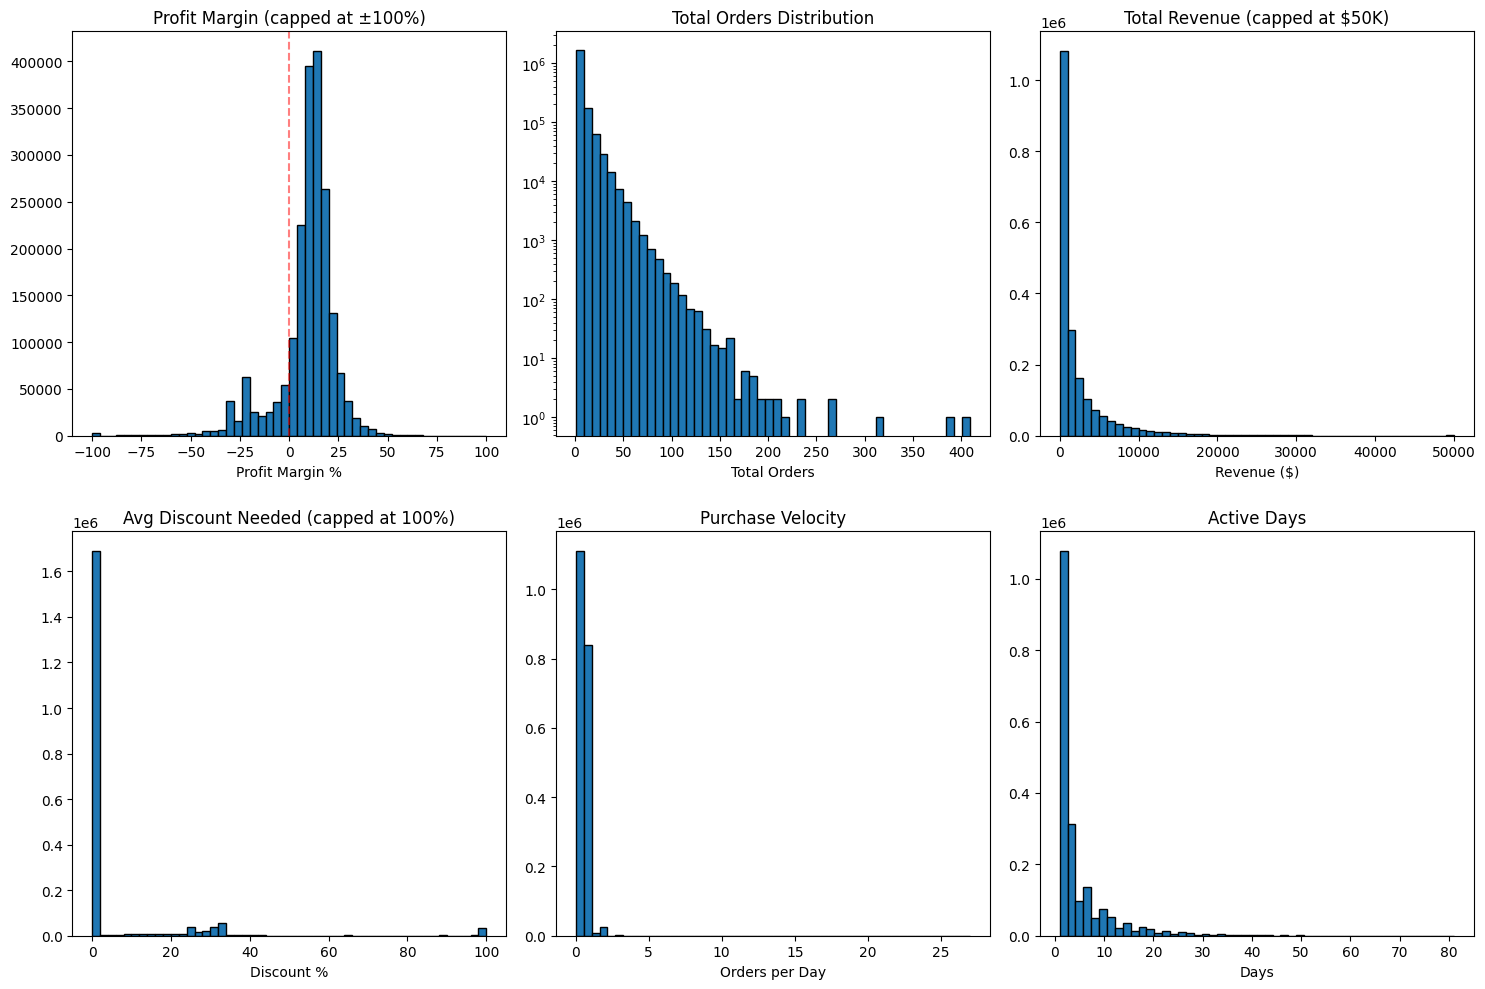

In [18]:
# Cell 16: Visualize outlier distributions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Profit margin distribution
axes[0, 0].hist(customer_features['profit_margin'].clip(-100, 100), bins=50, edgecolor='black')
axes[0, 0].set_title('Profit Margin (capped at ±100%)')
axes[0, 0].set_xlabel('Profit Margin %')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5)

# Total orders distribution
axes[0, 1].hist(customer_features['total_orders'], bins=50, edgecolor='black')
axes[0, 1].set_title('Total Orders Distribution')
axes[0, 1].set_xlabel('Total Orders')
axes[0, 1].set_yscale('log')

# Revenue distribution
axes[0, 2].hist(customer_features['total_revenue'].clip(0, 50000), bins=50, edgecolor='black')
axes[0, 2].set_title('Total Revenue (capped at $50K)')
axes[0, 2].set_xlabel('Revenue ($)')

# Avg discount needed
axes[1, 0].hist(customer_features['avg_discount_needed'].clip(0, 100), bins=50, edgecolor='black')
axes[1, 0].set_title('Avg Discount Needed (capped at 100%)')
axes[1, 0].set_xlabel('Discount %')

# Purchase velocity
axes[1, 1].hist(customer_features['purchase_velocity'], bins=50, edgecolor='black')
axes[1, 1].set_title('Purchase Velocity')
axes[1, 1].set_xlabel('Orders per Day')

# Active days
axes[1, 2].hist(customer_features['active_days'], bins=50, edgecolor='black')
axes[1, 2].set_title('Active Days')
axes[1, 2].set_xlabel('Days')

plt.tight_layout()
plt.savefig('outlier_distributions.png', dpi=100)
plt.show()

In [11]:
non_negative_features = [
    'total_orders', 'unique_products', 'total_quantity', 
    'unique_brands', 'active_days', 'customer_lifetime_days'
]

print("\nFeatures with negative values (shouldn't exist):")
for feat in non_negative_features:
    if feat in seg_data_clean.columns:
        negatives = (seg_data_clean[feat] < 0).sum()
        if negatives > 0:
            print(f"{feat}: {negatives:,} negative values")

# Check impossible combinations
print("\n" + "="*80)
print("Impossible data combinations:")

# Customers with 0 orders but have revenue
if 'total_orders' in customer_features.columns and 'total_revenue' in customer_features.columns:
    impossible = ((customer_features['total_orders'] == 0) & 
                  (customer_features['total_revenue'] > 0)).sum()
    print(f"Customers with 0 orders but revenue > 0: {impossible:,}")

# Customers with orders but 0 unique products
if 'total_orders' in customer_features.columns and 'unique_products' in customer_features.columns:
    impossible = ((customer_features['total_orders'] > 0) & 
                  (customer_features['unique_products'] == 0)).sum()
    print(f"Customers with orders > 0 but unique_products = 0: {impossible:,}")

# avg_days_between_orders = 999 check
if 'avg_days_between_orders' in seg_data_clean.columns:
    single_buyers = (seg_data_clean['avg_days_between_orders'] == 999).sum()
    print(f"Single purchase customers (avg_days = 999): {single_buyers:,} ({single_buyers/len(seg_data_clean)*100:.1f}%)")


Features with negative values (shouldn't exist):

Impossible data combinations:
Customers with 0 orders but revenue > 0: 0
Customers with orders > 0 but unique_products = 0: 0
Single purchase customers (avg_days = 999): 761,246 (38.3%)


In [ ]:
reference_date = pd.to_datetime('2022-07-10')
print(f"Reference date (last date in dataset): {reference_date.date()}")
print(f"All features should use data up to this date only\n")

# Check temporal features are calculated correctly
print("Temporal features (should not leak future data):")
temporal_features = [
    'recency_days', 'orders_last_30d', 'orders_last_60d', 'orders_last_90d',
    'revenue_last_30d', 'revenue_last_60d', 'revenue_last_90d',
    'items_last_30d', 'items_last_60d', 'items_last_90d'
]

for feat in temporal_features:
    if feat in customer_features.columns:
        print(f"  {feat}: OK")

print("\nFeatures using last_purchase (should be <= 2022-07-10):")
if 'last_purchase' in customer_features.columns:
    last_purchase_max = pd.to_datetime(customer_features['last_purchase']).max()
    if last_purchase_max <= reference_date:
        print(f"Max last_purchase: {last_purchase_max.date()} - OK")
    else:
        print(f"LEAKAGE: Max last_purchase: {last_purchase_max.date()} (after reference date!)")

print("No data leakage detected if all temporal features use reference_date")

Reference date (last date in dataset): 2022-07-10
All features should use data up to this date only

Temporal features (should not leak future data):
  recency_days: OK
  orders_last_30d: OK
  orders_last_60d: OK
  orders_last_90d: OK
  revenue_last_30d: OK
  revenue_last_60d: OK
  revenue_last_90d: OK
  items_last_30d: OK
  items_last_60d: OK
  items_last_90d: OK

Features using last_purchase (should be <= 2022-07-10):
  Max last_purchase: 2022-07-10 - OK

✓ No data leakage detected if all temporal features use reference_date


In [13]:
skewness = seg_data_clean.skew().sort_values(ascending=False)

print("\nHighly skewed features (|skewness| > 3):")
high_skew = skewness[skewness.abs() > 3]
for feat, skew in high_skew.items():
    print(f"{feat}: {skew:.2f}")

# Check zero-inflation
print("\n" + "="*80)
print("Zero-inflated features (>50% zeros):")
zero_pct = ((seg_data_clean == 0).sum() / len(seg_data_clean) * 100).sort_values(ascending=False)
high_zeros = zero_pct[zero_pct > 50]
for feat, pct in high_zeros.items():
    print(f"{feat}: {pct:.1f}% zeros")

# Check if transformation might be needed
print("\n" + "="*80)
print("Features that may need transformation:")
print("(High skew OR >50% zeros)")
needs_transform = set(high_skew.index) | set(high_zeros.index)
print(f"Total: {len(needs_transform)} features")
for feat in sorted(needs_transform):
    print(f"  - {feat}")


Highly skewed features (|skewness| > 3):
avg_discount_needed: 132.23
price_variance: 124.79
discount_sensitivity: 112.31
avg_quantity_per_order: 13.20
small_discount_pct: 12.91
avg_revenue_per_order: 9.17
medium_discount_pct: 8.97
total_quantity: 6.69
min_price_paid: 6.45
total_revenue: 5.49
avg_price_point: 5.35
total_profit: 4.61
total_orders: 4.56
price_std: 3.70
active_days: 3.23
max_price_paid: 3.17
avg_products_per_order: 3.08
avg_brands_per_order: 3.02
profit_margin: -237.02

Zero-inflated features (>50% zeros):
small_discount_pct: 98.8% zeros
medium_discount_pct: 97.6% zeros
discount_sensitivity: 89.2% zeros
high_discount_pct: 87.6% zeros
avg_discount_needed: 85.0% zeros
bulk_orders_pct: 71.5% zeros
product_repeat_rate: 58.3% zeros
std_days_between_orders: 53.4% zeros

Features that may need transformation:
(High skew OR >50% zeros)
Total: 23 features
  - active_days
  - avg_brands_per_order
  - avg_discount_needed
  - avg_price_point
  - avg_products_per_order
  - avg_quantit

In [14]:
# Calculate variance and coefficient of variation
variance = seg_data_clean.var()
cv = seg_data_clean.std() / seg_data_clean.mean().replace(0, np.nan)

# Near-zero variance (CV < 0.1 means very low variability)
print("\nFeatures with very low variance (CV < 0.1):")
low_var = cv[cv < 0.1].sort_values()
if len(low_var) > 0:
    for feat, cv_val in low_var.items():
        unique_vals = seg_data_clean[feat].nunique()
        print(f"{feat}: CV={cv_val:.4f}, unique_values={unique_vals}")
else:
    print("None found")

# Check features with only 1-2 unique values
print("\n" + "="*80)
print("Features with very few unique values:")
for col in seg_data_clean.columns:
    n_unique = seg_data_clean[col].nunique()
    if n_unique <= 5:
        print(f"{col}: {n_unique} unique values")
        print(f"  Values: {seg_data_clean[col].unique()[:10]}")


Features with very low variance (CV < 0.1):
None found

Features with very few unique values:


In [19]:
# Load sales data
sales = pd.read_csv('sales_cleaned.csv')
sales.columns = sales.columns.str.replace('dim_customer_key', 'customer_id')
sales.columns = sales.columns.str.replace('procured_quantity', 'quantity')
sales.columns = sales.columns.str.replace('unit_selling_price', 'unit_price')
sales.columns = sales.columns.str.replace('total_discount_amount', 'discount')

print(f"Total transactions: {len(sales):,}")

# Calculate revenue at transaction level
sales['revenue'] = (sales['unit_price'] * sales['quantity']) - sales['discount']

print("\nChecking business logic violations:")

Total transactions: 46,448,124

Checking business logic violations:


In [20]:
# Cell 20: Identify impossible transactions

# Check 1: Discount > Revenue (impossible)
sales['discount_exceeds_revenue'] = sales['discount'] > (sales['unit_price'] * sales['quantity'])

impossible_transactions = sales['discount_exceeds_revenue'].sum()
print(f"\nTransactions where discount > unit_price × quantity: {impossible_transactions:,}")
print(f"Percentage: {impossible_transactions/len(sales)*100:.2f}%")

if impossible_transactions > 0:
    print("\nSample of impossible transactions:")
    print(sales[sales['discount_exceeds_revenue']][['customer_id', 'unit_price', 'quantity', 
                                                      'discount', 'revenue']].head(10))
    
    # How many customers affected?
    affected_customers = sales[sales['discount_exceeds_revenue']]['customer_id'].nunique()
    print(f"\nCustomers affected: {affected_customers:,}")

# Check 2: Negative unit prices
negative_prices = (sales['unit_price'] < 0).sum()
print(f"\nTransactions with negative unit_price: {negative_prices:,}")

# Check 3: Negative quantities
negative_qty = (sales['quantity'] < 0).sum()
print(f"Transactions with negative quantity: {negative_qty:,}")

# Check 4: Zero prices with positive quantity
zero_price = ((sales['unit_price'] == 0) & (sales['quantity'] > 0)).sum()
print(f"Transactions with $0 price but quantity > 0: {zero_price:,}")


Transactions where discount > unit_price × quantity: 231
Percentage: 0.00%

Sample of impossible transactions:
         customer_id  unit_price  quantity  discount  revenue
136213      16908735        19.0         3      58.0     -1.0
291288      17024439        39.0         1      40.0     -1.0
475796      18330883        50.0         1      75.0    -25.0
548958        815083        50.0         1      51.0     -1.0
1400541     12776690        52.0         1      76.0    -24.0
1511812       644324        95.0         1      96.0     -1.0
1635507       919138        20.0         4      81.0     -1.0
1826106        16892       242.0         1     243.0     -1.0
1846232       334237        56.0         1     106.0    -50.0
2000750     12858442       153.0         1     154.0     -1.0

Customers affected: 205

Transactions with negative unit_price: 0
Transactions with negative quantity: 0
Transactions with $0 price but quantity > 0: 47,430


In [25]:

# Calculate pre-discount total
sales['pre_discount_total'] = sales['unit_price'] * sales['quantity']

# Rule 1: Free items (unit_price = 0) - these are fine
free_items = ((sales['unit_price'] == 0) & (sales['quantity'] > 0)).sum()
print(f"Free items (unit_price = 0): {free_items:,}")
print("  → These are legitimate promotional/sample items\n")

# Rule 2: Discount cannot exceed pre-discount total
sales['discount_exceeds_price'] = sales['discount'] > sales['pre_discount_total']
impossible = sales['discount_exceeds_price'].sum()

print(f"Impossible discounts (discount > unit_price × quantity): {impossible:,}")
print(f"Percentage: {impossible/len(sales)*100:.4f}%")

if impossible > 0:
    print("\nExamples:")
    bad = sales[sales['discount_exceeds_price']].copy()
    print(bad[['customer_id', 'unit_price', 'quantity', 'pre_discount_total', 
               'discount', 'revenue']].head(10))
    print(f"\nCustomers affected: {bad['customer_id'].nunique():,}")

Free items (unit_price = 0): 47,430
  → These are legitimate promotional/sample items

Impossible discounts (discount > unit_price × quantity): 231
Percentage: 0.0005%

Examples:
         customer_id  unit_price  quantity  pre_discount_total  discount  \
136213      16908735        19.0         3                57.0      58.0   
291288      17024439        39.0         1                39.0      40.0   
475796      18330883        50.0         1                50.0      75.0   
548958        815083        50.0         1                50.0      51.0   
1400541     12776690        52.0         1                52.0      76.0   
1511812       644324        95.0         1                95.0      96.0   
1635507       919138        20.0         4                80.0      81.0   
1826106        16892       242.0         1               242.0     243.0   
1846232       334237        56.0         1                56.0     106.0   
2000750     12858442       153.0         1               153.